# ASTR596 HW01

**1.**

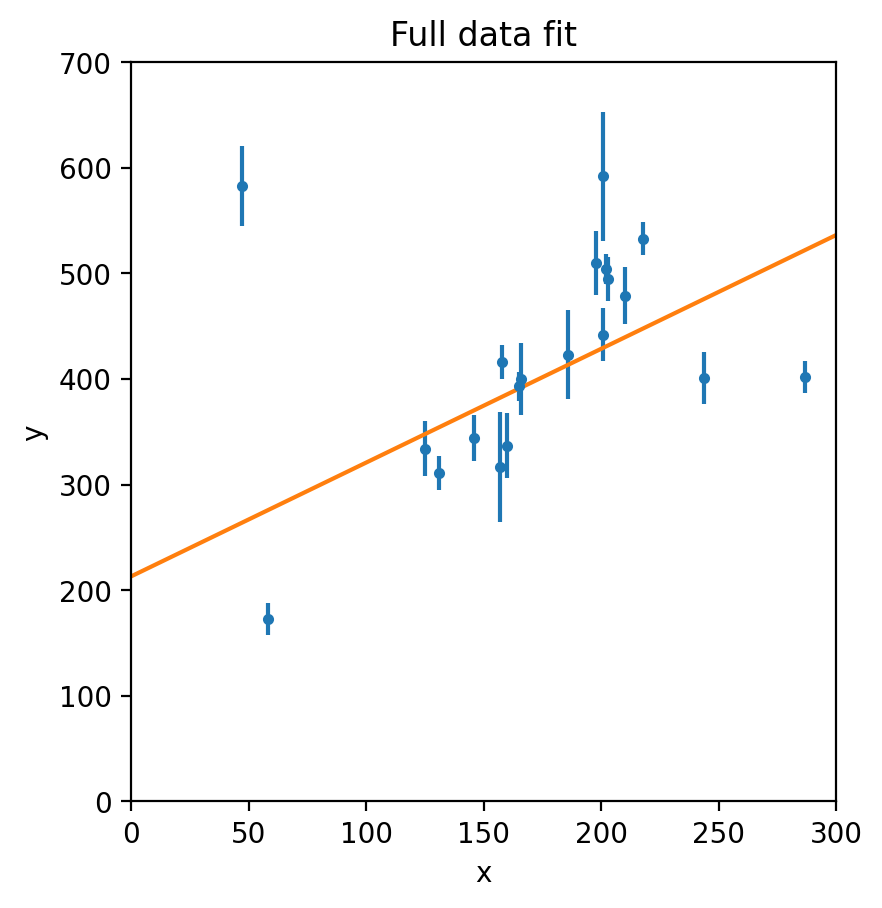

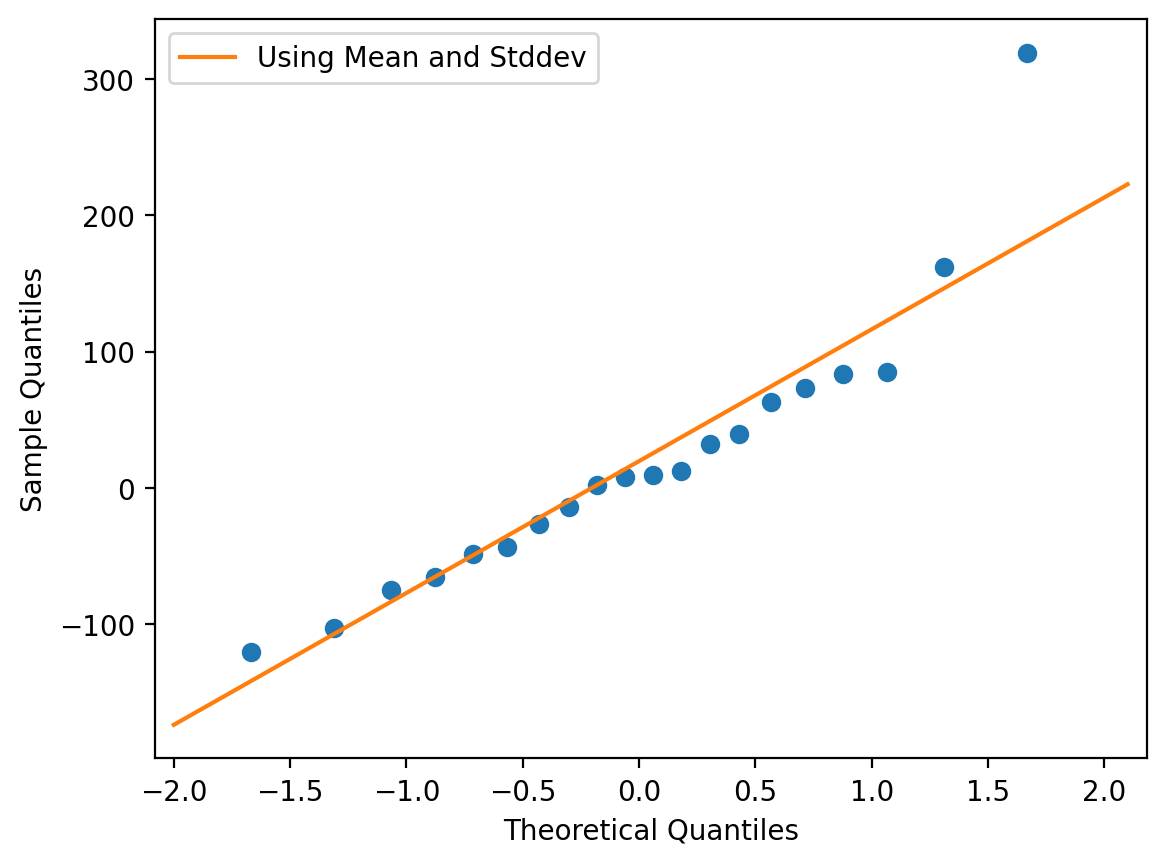

In [300]:
import numpy as np
from numpy.linalg import inv
from matplotlib import pyplot as plt
import scipy.optimize
from scipy.optimize import minimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test


data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

#initial attempt at defining the -lnL(a,b) function in need of minimization
def abfit(xs,ys,sig_y):
    def n_lnL(vals):
        a,b = vals[1], vals[0]
        yp = b+a*xs
        sqrloss = (ys-yp)**2/(sig_y**2)
        chisq = np.sum(sqrloss)
        return 0.5*chisq


    minparams = minimize(n_lnL, [1,1]).x
    return minparams

def plotfunc(xs,ys,sig_y, minimized_params, title, resid=False):

    if resid == False:
        plt.subplot(111)
        plt.errorbar(xs, ys, yerr = sig_y, marker = ".", linestyle = "");
        plt.xlabel("x"); plt.ylabel("y"); plt.title(title)
        plt.xlim(0, 300);  plt.ylim(0, 700);
        x2 = np.linspace(0, 300, ys.size)
        y2 = minimized_params[0]+minimized_params[1]*x2
        plt.plot(x2, y2);
    else:
        plt.figure().set_figwidth(10)
        plt.subplot(121)
        plt.errorbar(xs, ys, yerr = sig_y, marker = ".", linestyle = "");
        plt.xlabel("x"); plt.ylabel("y"); plt.title(title)
        plt.xlim(0, 300);  plt.ylim(0, 700);
        x2 = np.linspace(0, 300, ys.size)
        y2 = minimized_params[0]+minimized_params[1]*x2
        plt.plot(x2, y2);

        #qqplot of the residuals along with a best fit line of residuals
        resids = ys-(minimized_params[0]+minimized_params[1]*xs)
        sm.qqplot(resids, dist=st.norm);

        mus = resids.mean()
        stds = resids.std()
        xs2 = np.linspace(-2,2.1,100)
        plt.plot(xs2,mus+stds*xs2, 'C1-',label = 'Using Mean and Stddev')
        plt.legend()

plotfunc(x,y,dy,abfit(x,y,dy),title ='Full data fit', resid=True)

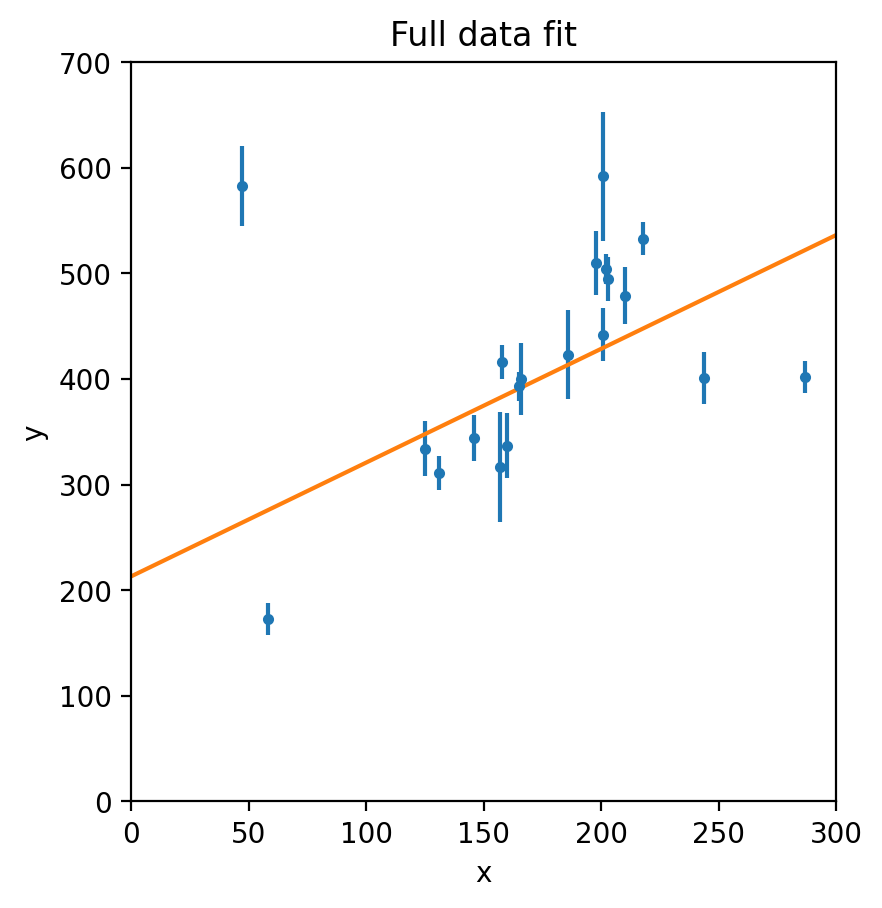

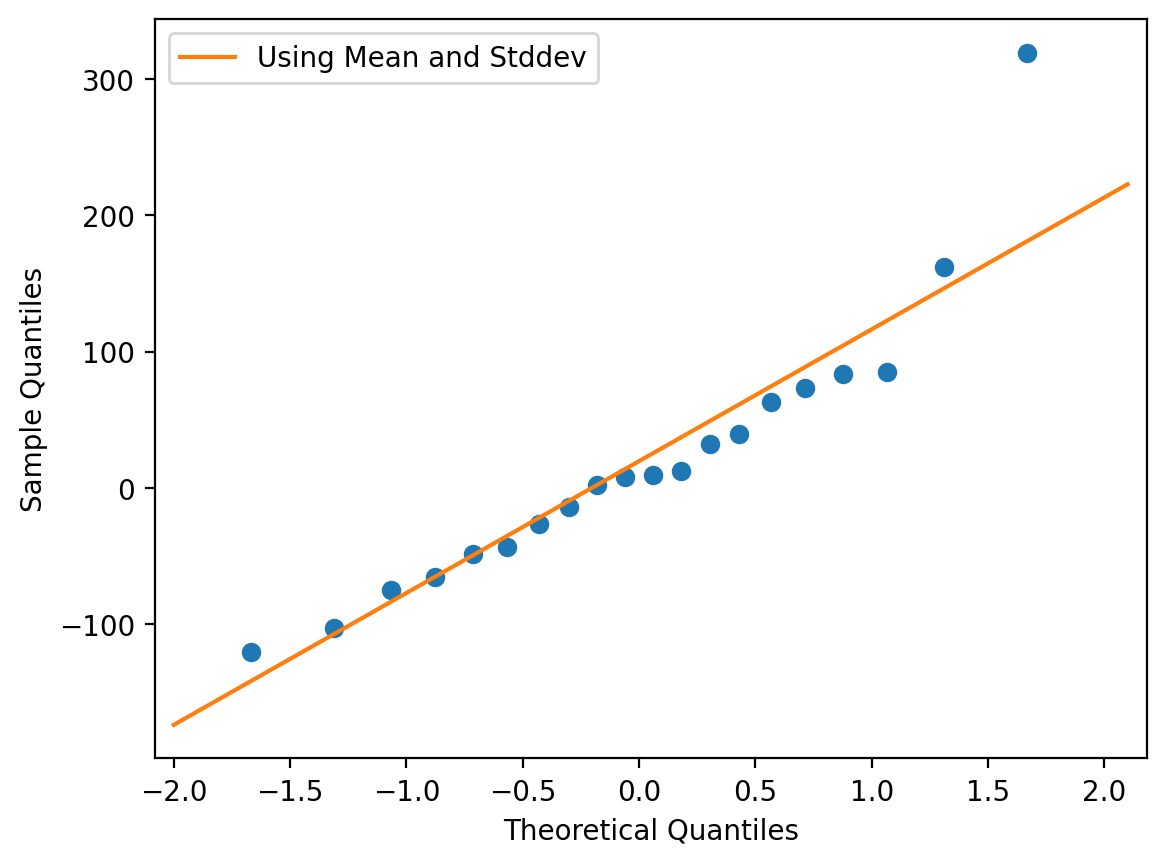

In [273]:
import numpy as np
from numpy.linalg import inv
from matplotlib import pyplot as plt
import scipy.optimize
from scipy.optimize import minimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

def ab_fit(xs,ys,sig_y,title, resid=False):
    #from the reading: [b,m] = X = [A.T *C^-1*A]^-1 * [A.T*C^-1*Y] will return b, m (m=a for our example)
    # such that b,m minimize the chi-squared function
    #Yes, the majority of this solution is pulled from the solution to Exercise 2 of the provided reading,
    # but I wanted to show that I understand what that exercise was doing. 


    #create column vector for y values
    Y = ys
    #create matrix of const+x values
    A = np.column_stack([np.ones_like(xs), xs])
    #create a diagonalized matrix of the covariances for each given y value (dy^2)
    CovMat = np.diag(sig_y**2)

    #as is the case for solving for b, m via linear algebra, the values for b,m are stored in a matrix X
    # this matrix X 
    X = inv(A.T @ inv(CovMat) @ A) @ (A.T @ inv(CovMat) @ Y)
    #S2 = inv(A.T @ inv(CovMat) @ A)
    
    
    if resid == False:
        plt.subplot(111)
        plt.errorbar(xs, ys, yerr = sig_y, marker = ".", linestyle = "");
        plt.xlabel("x"); plt.ylabel("y"); plt.title(title)
        plt.xlim(0, 300);  plt.ylim(0, 700);
        x2 = np.linspace(0, 300, ys.size)
        A2 = np.column_stack([np.ones_like(x2), x2])
        y2 = A2 @ X
        plt.plot(x2, y2);
    else:
        plt.figure().set_figwidth(10)
        plt.subplot(121)
        plt.errorbar(xs, ys, yerr = sig_y, marker = ".", linestyle = "");
        plt.xlabel("x"); plt.ylabel("y"); plt.title(title)
        plt.xlim(0, 300);  plt.ylim(0, 700);
        x2 = np.linspace(0, 300, ys.size)
        A2 = np.column_stack([np.ones_like(x2), x2])
        y2 = A2 @ X
        plt.plot(x2, y2);
        

        
        #qqplot of the residuals along with a best fit line of residuals
        resids = ys-(A @ X)
        sm.qqplot(resids, dist=st.norm);
        
        mus = resids.mean()
        stds = resids.std()
        xs2 = np.linspace(-2,2.1,100)
        plt.plot(xs2,mus+stds*xs2, 'C1-',label = 'Using Mean and Stddev')
        plt.legend()
        
        
        
ab_fit(x,y,dy,'Full data fit', resid=True)

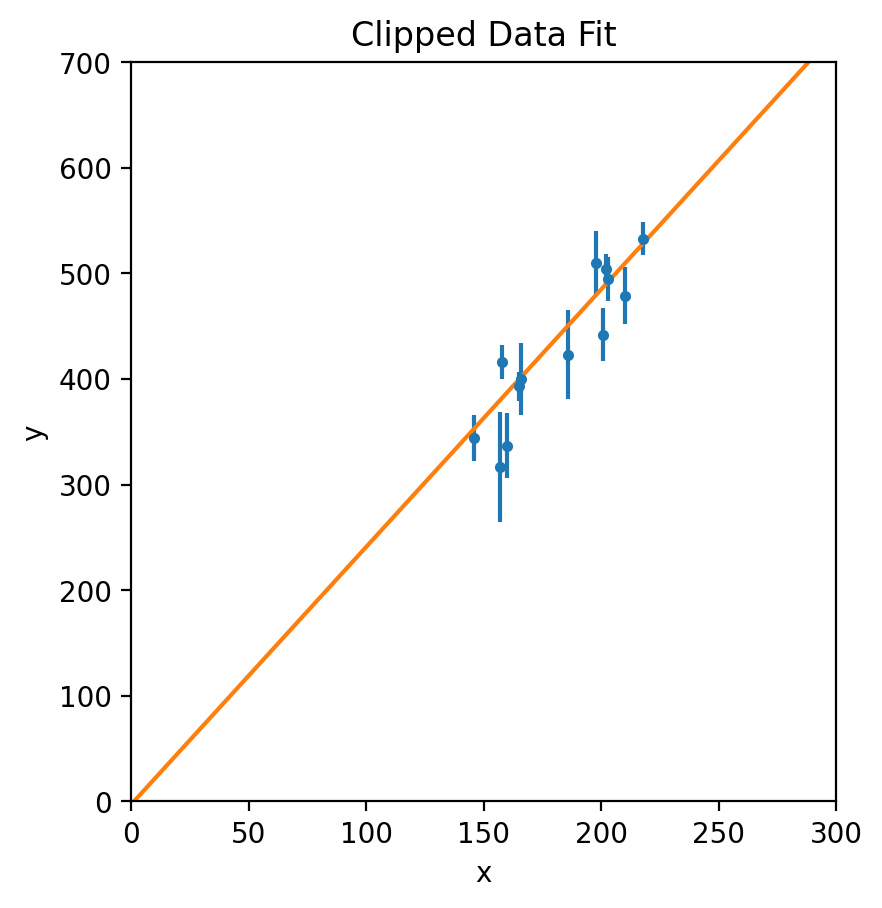

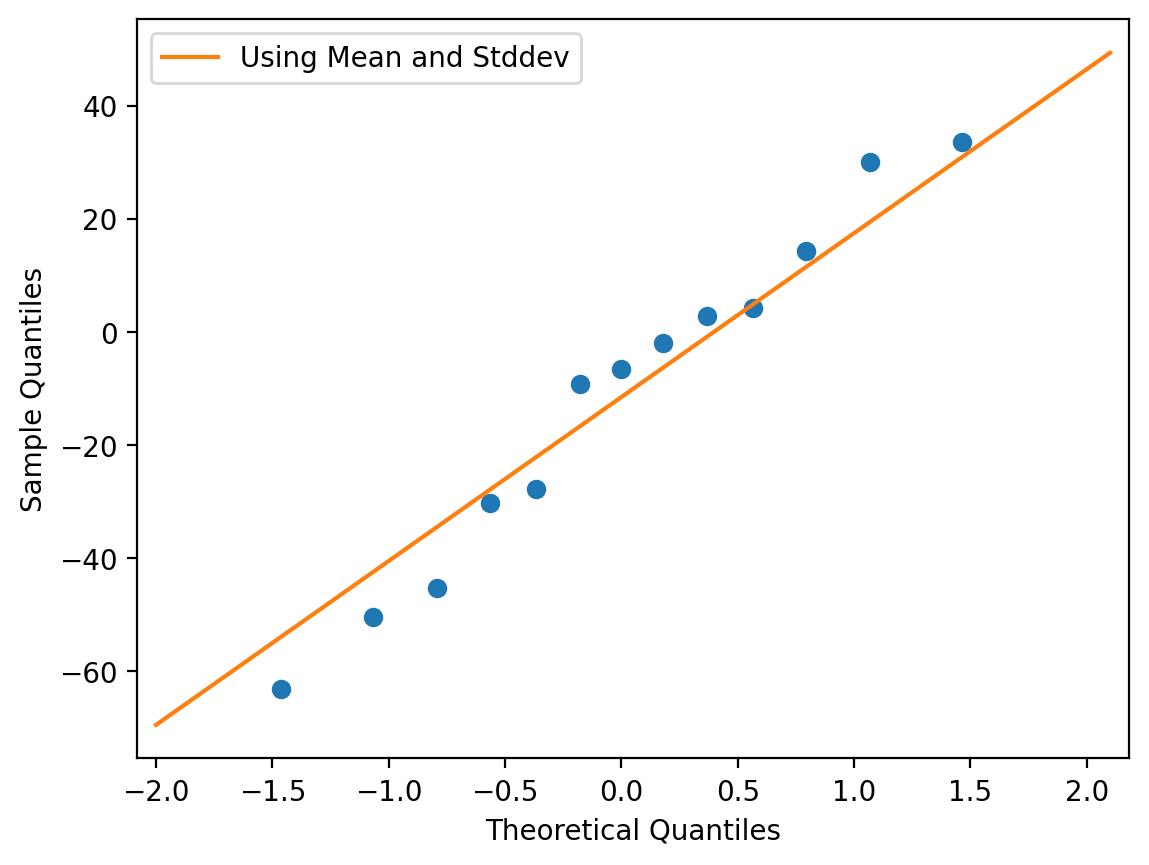

In [290]:
#remove outliers via sigma clipping
from astropy.stats import sigma_clip

def clip(xs,ys,sig_y):
    clipx = sigma_clip((x), sigma=1.75,cenfunc='mean', masked=True)
    clipy = sigma_clip((y), sigma=1.75,cenfunc='mean', masked=True)

    newy = []
    newx = []
    newdy = []
    for i in range(len(newdat[1])):
        if clipx[i] == x[i] and clipy[i]==y[i]:
            newx.append(newdat[0][i])
            newdy.append(dy[i])
            newy.append(newdat[1][i])

    newdy = np.asarray(newdy)
    newx = np.asarray(newx)
    newy = np.asarray(newy)
    return [newx, newy, newdy]

abfit(clip(x,y,dy)[0],clip(x,y,dy)[1],clip(x,y,dy)[2],'Clipped Data Fit', resid = True)


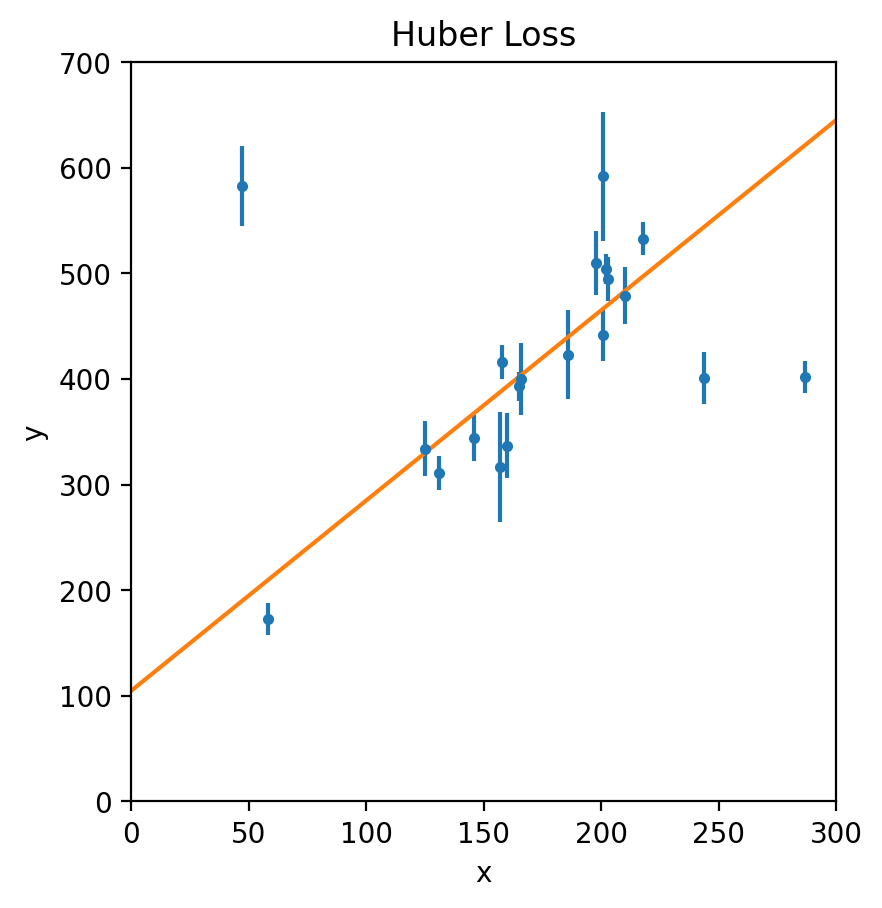

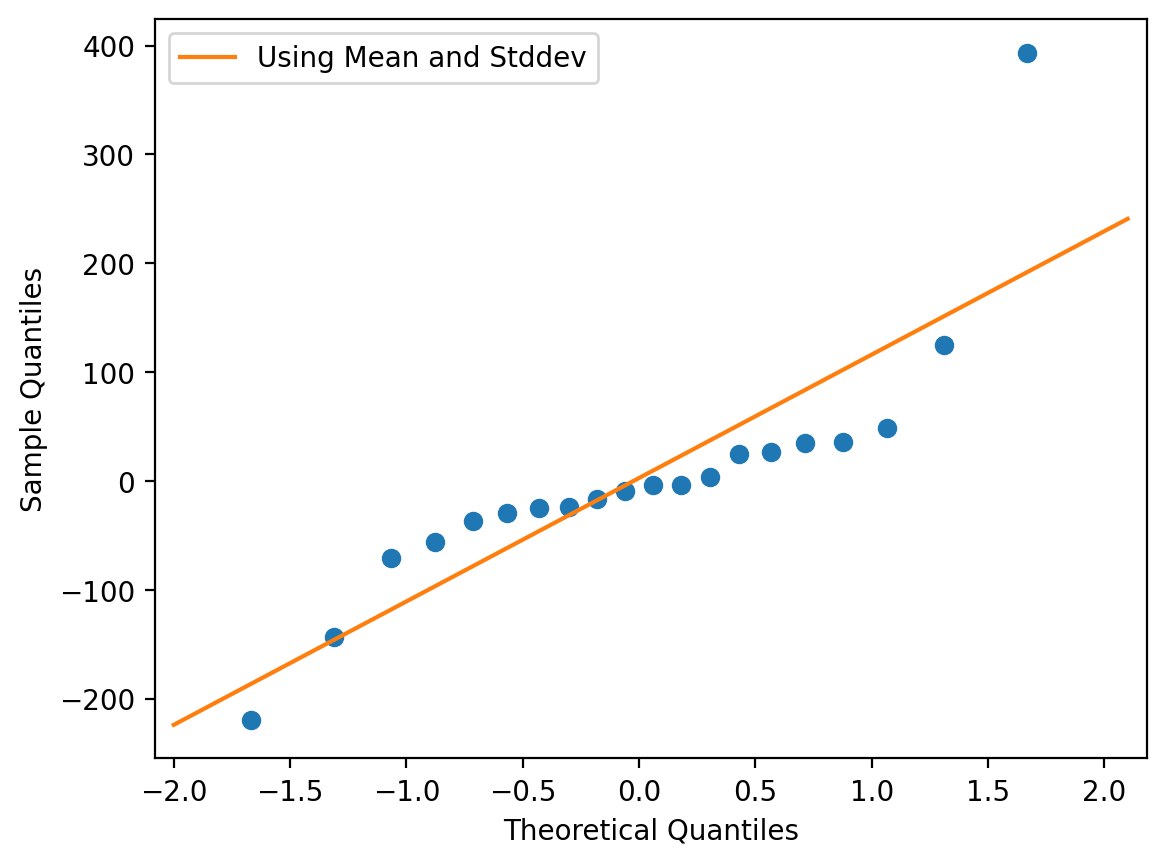

In [303]:
#define new Hubber loss function


def newfit(xs,ys,sig_y):
    
    def hubloss(vals):
        a,b = vals[1], vals[0]
        yp = b+a*xs
        u = ys-yp
        loss = 0
        for i in range(len(u)):
            if np.abs(u[i]) <= sig_y[i]:
                loss+= 0.5*(u[i])**2/(sig_y[i]**2)

            elif np.abs(u[i]) > dy[i]:
                loss += sig_y[i]*(np.abs(u[i])-0.5*sig_y[i])
        return loss
    
    minparams = minimize(hubloss, [1,1]).x
        
    return minparams


plotfunc(x,y,dy,newfit(x,y,dy),'Huber Loss', resid='True')

**2.**

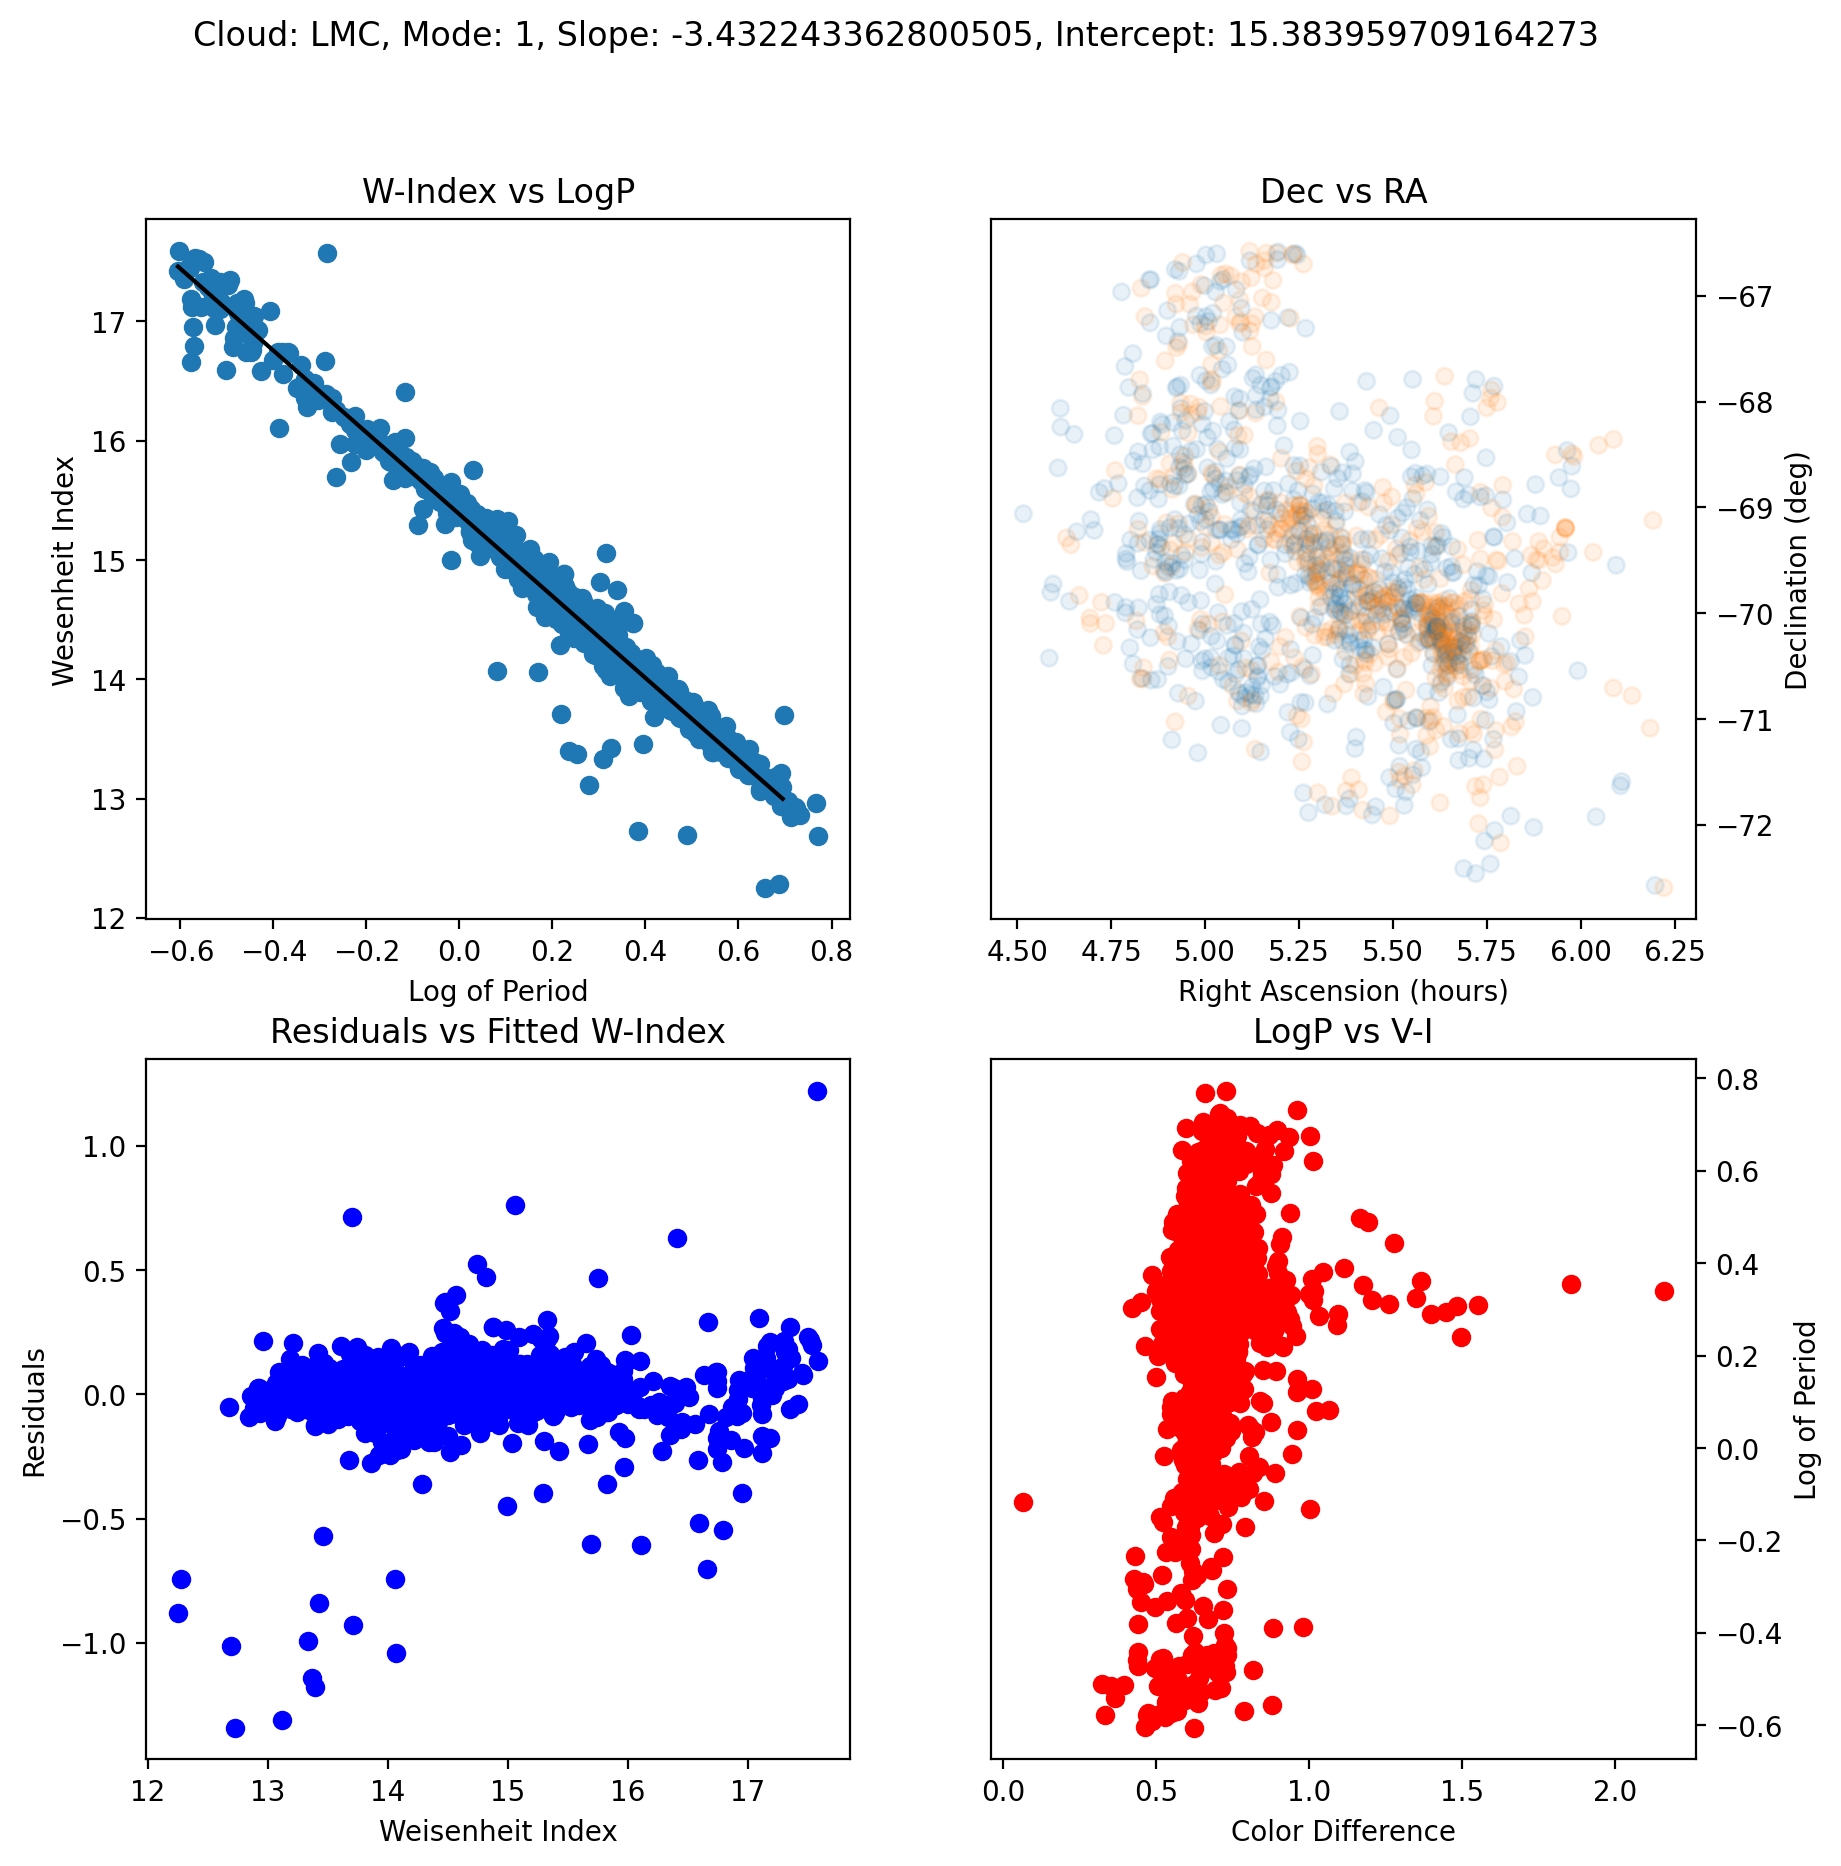

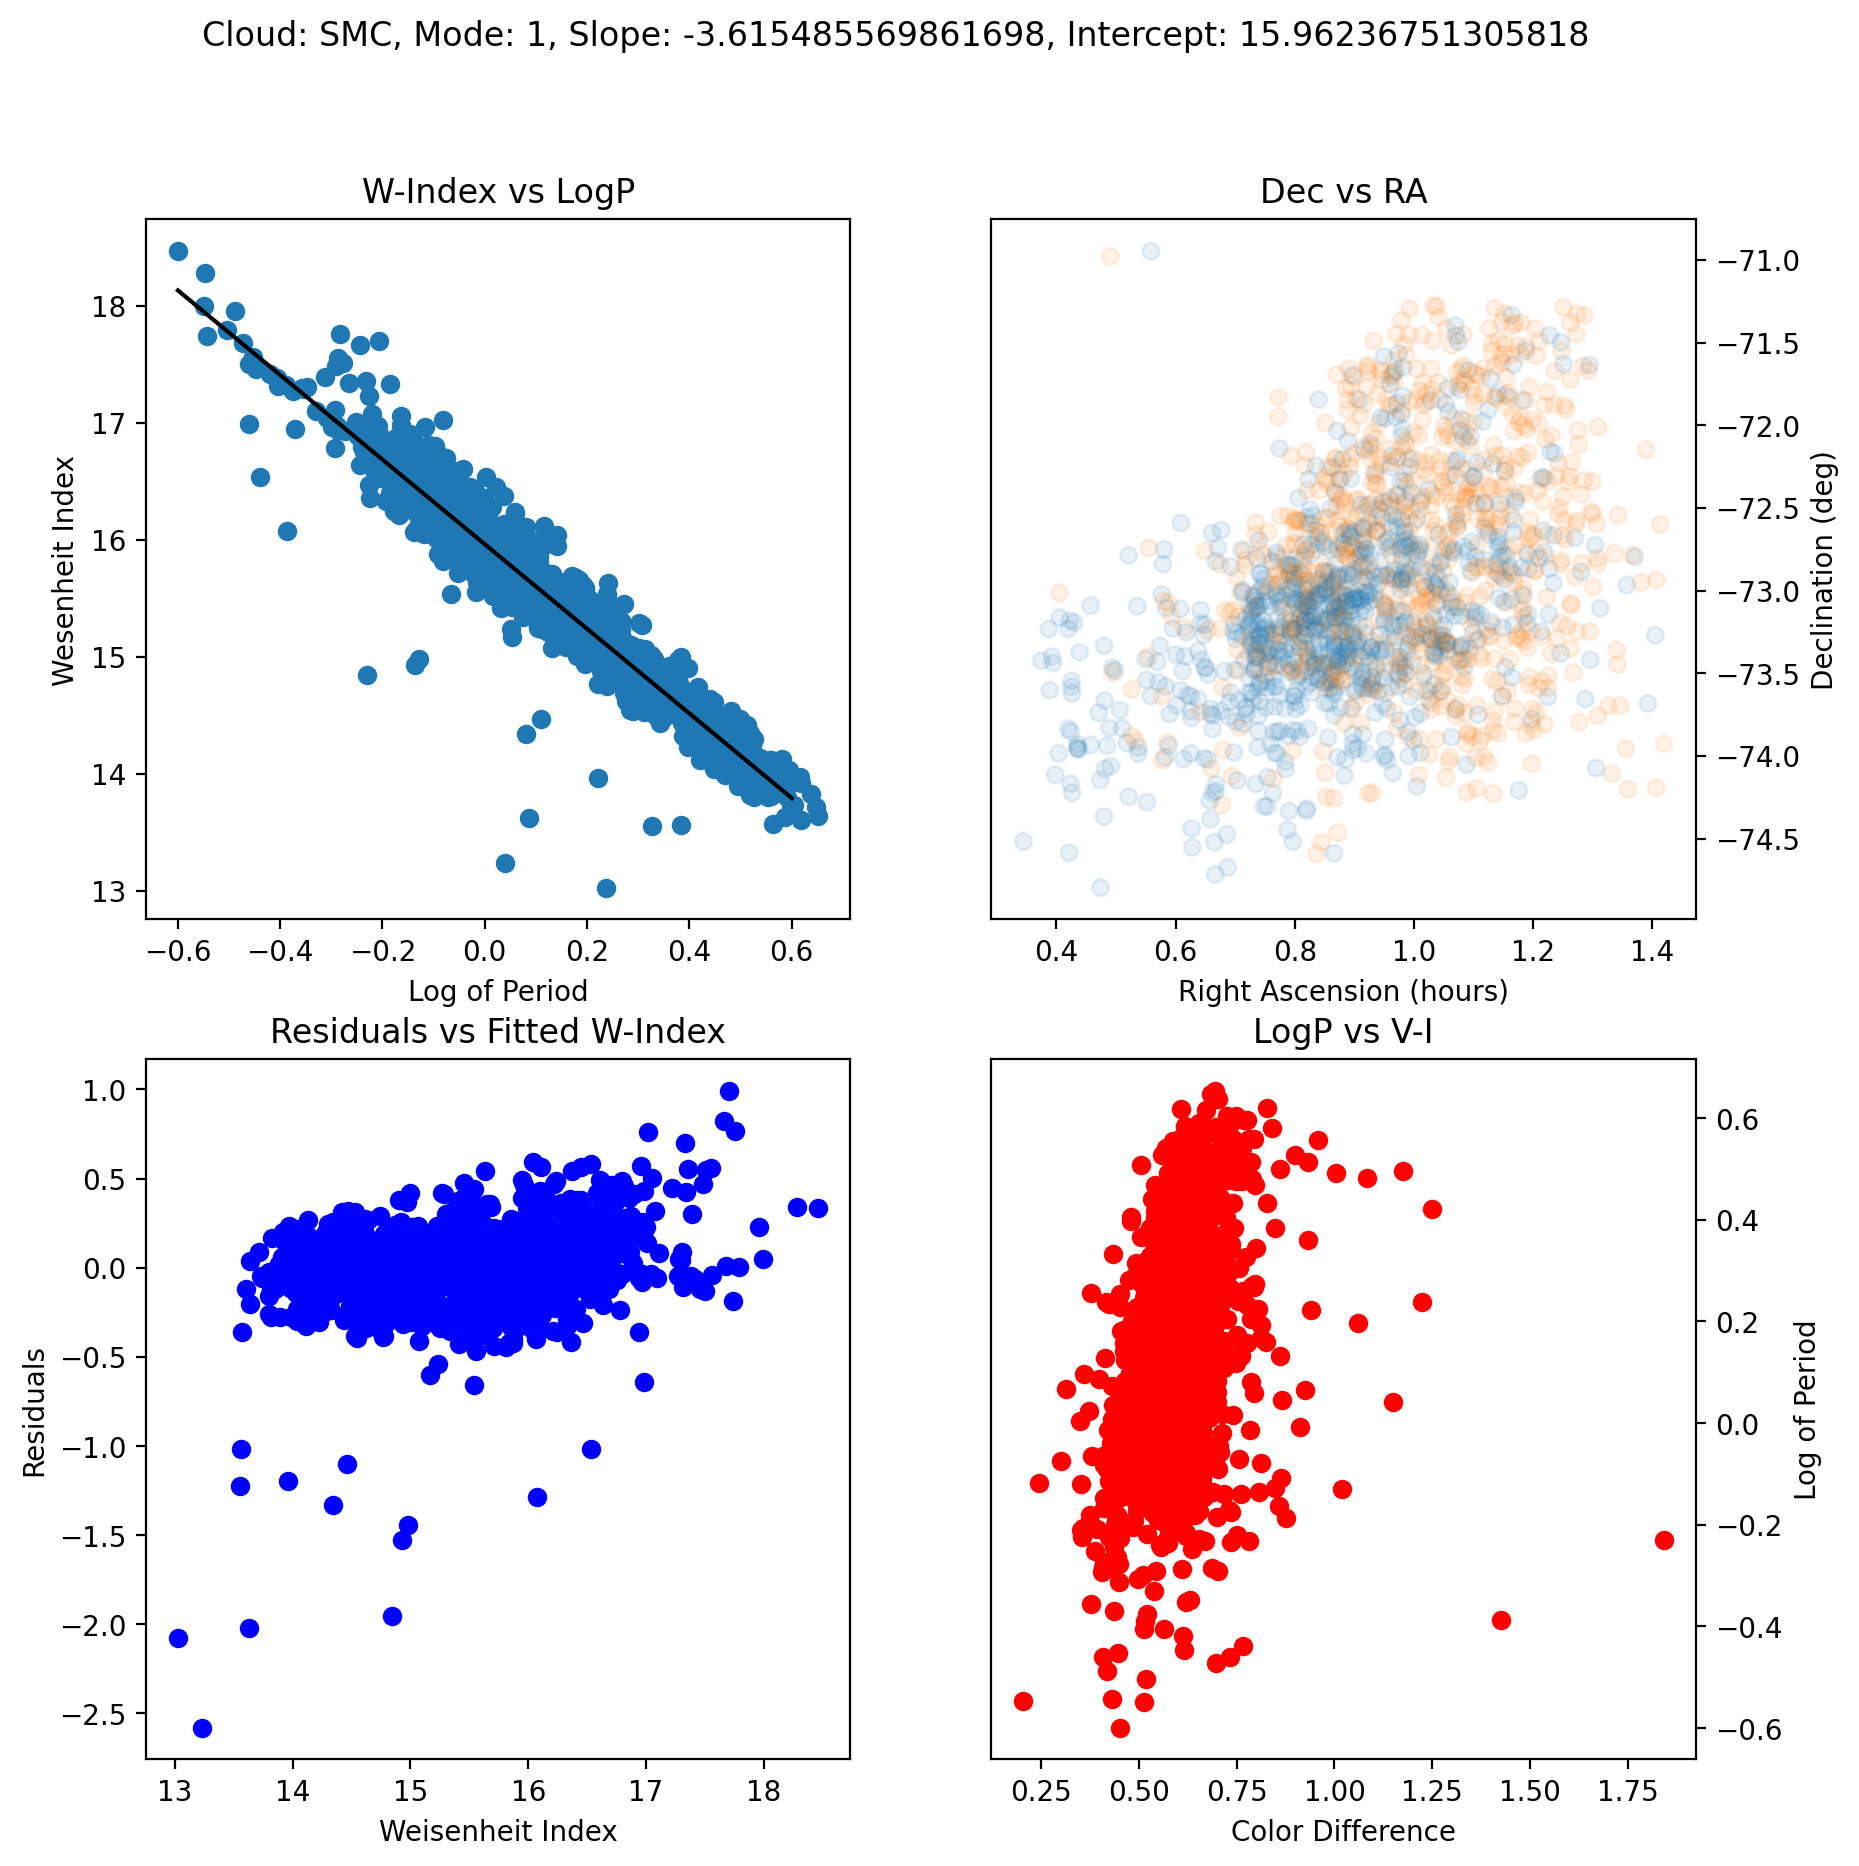

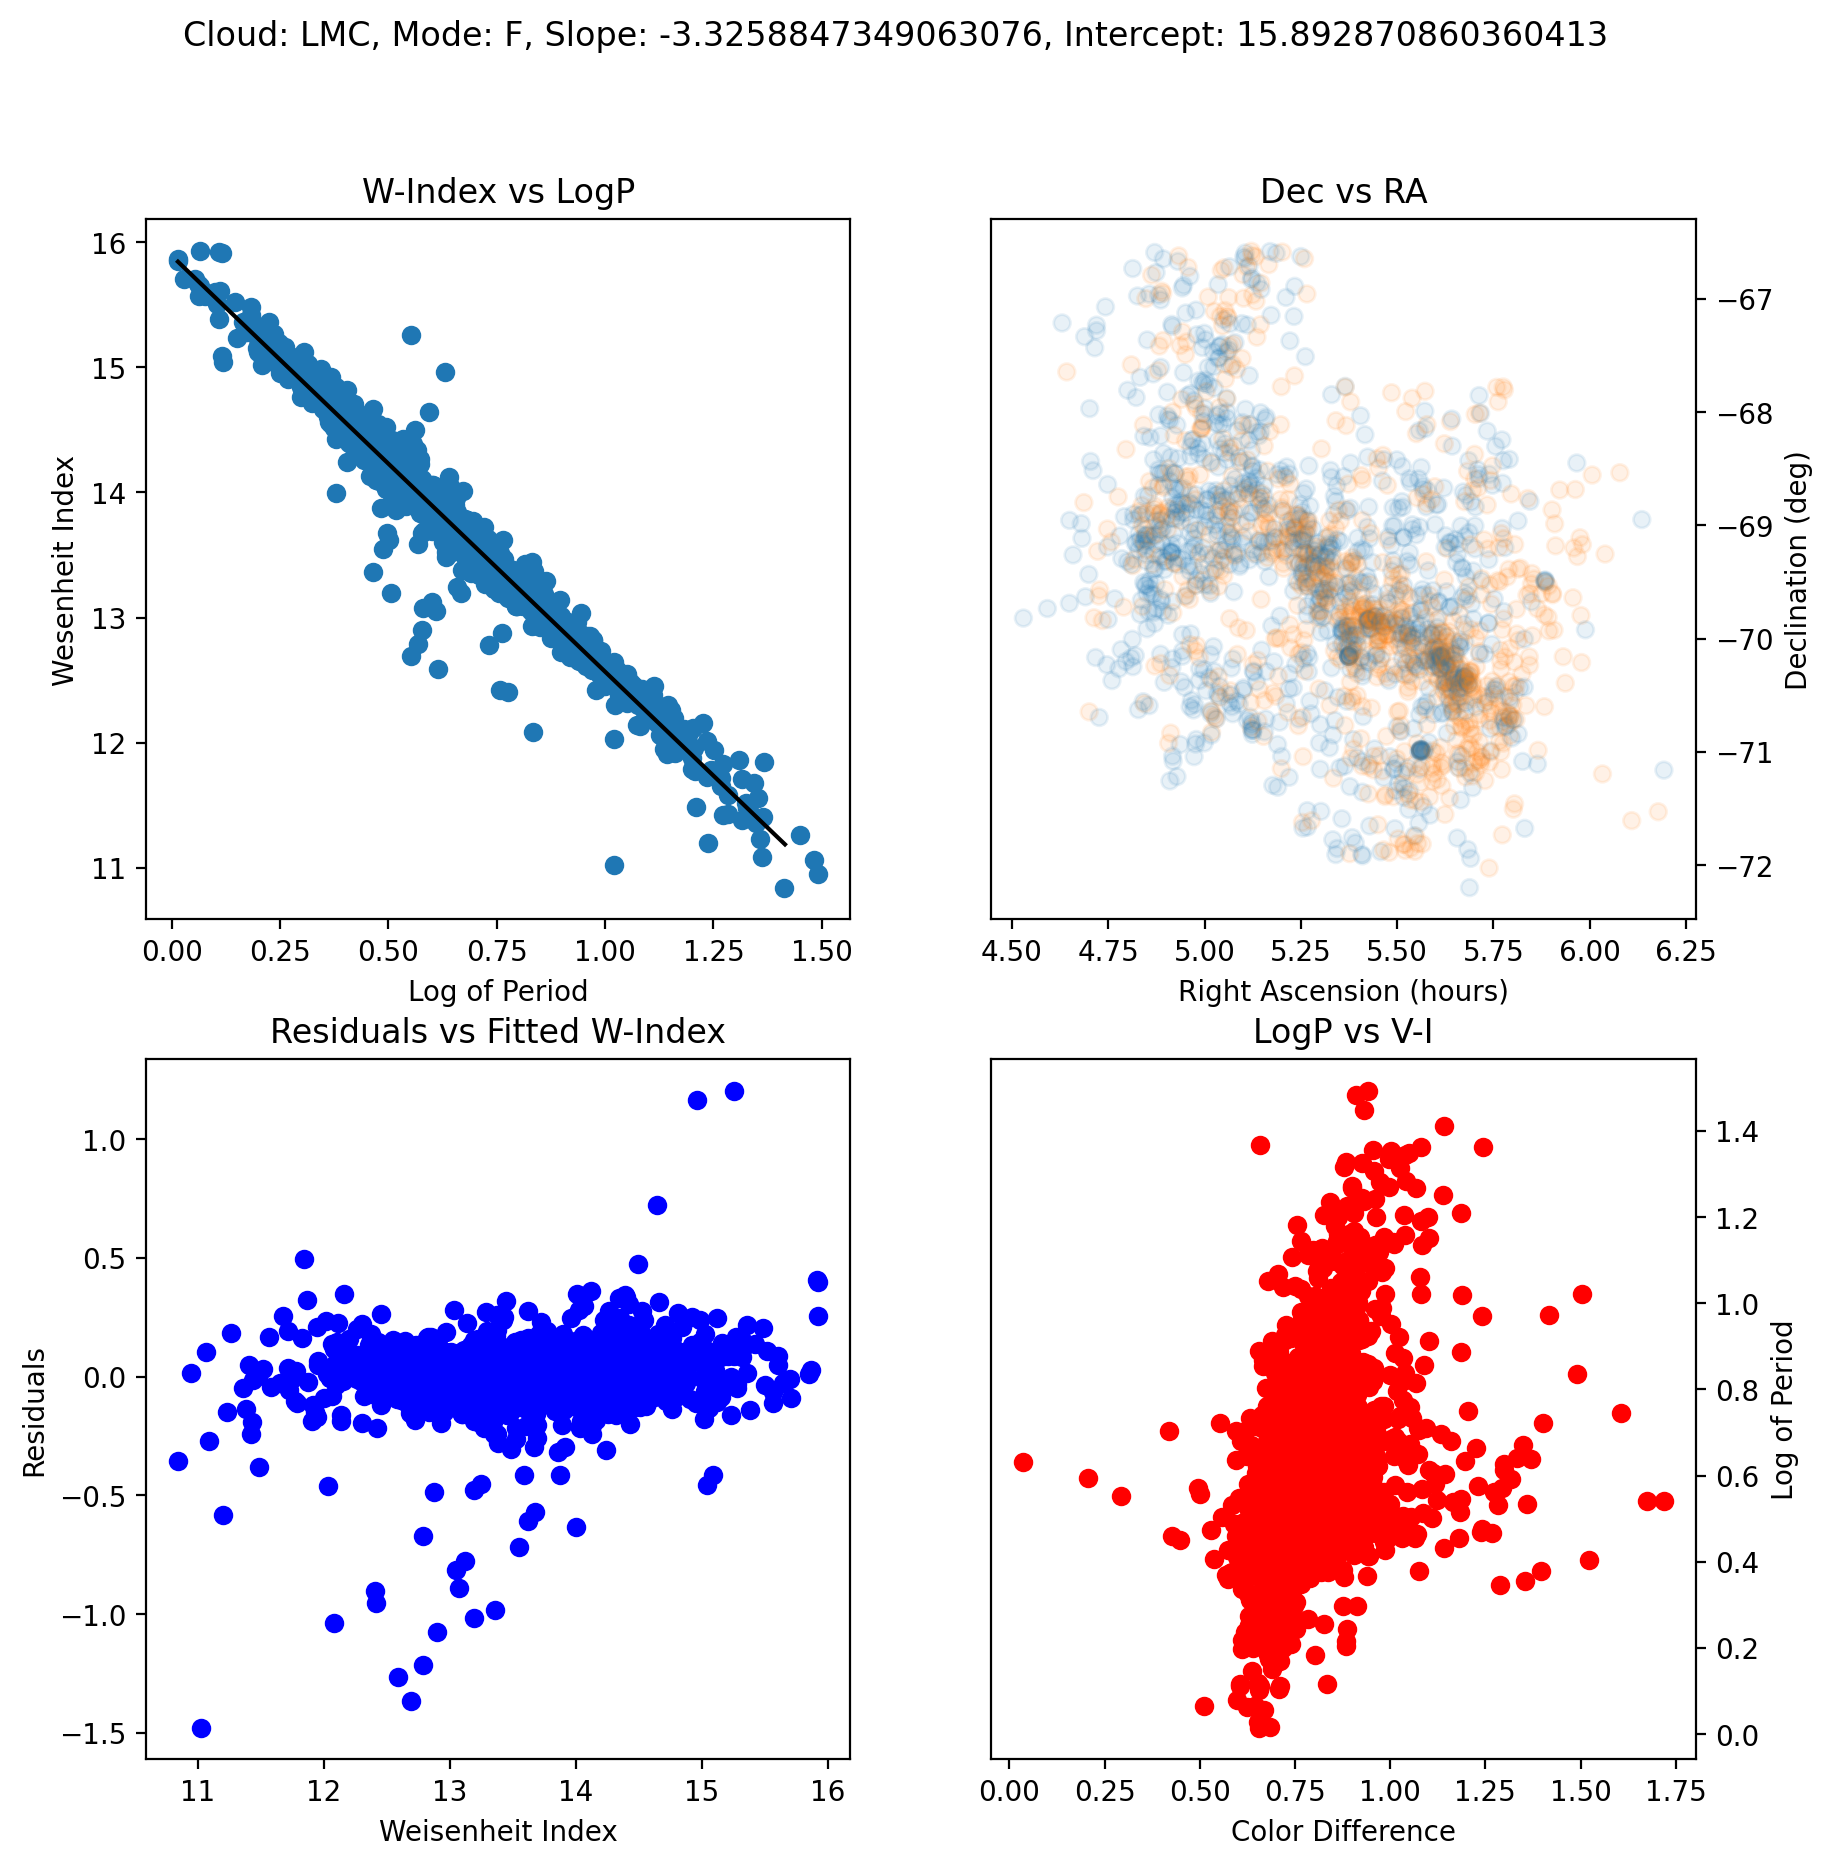

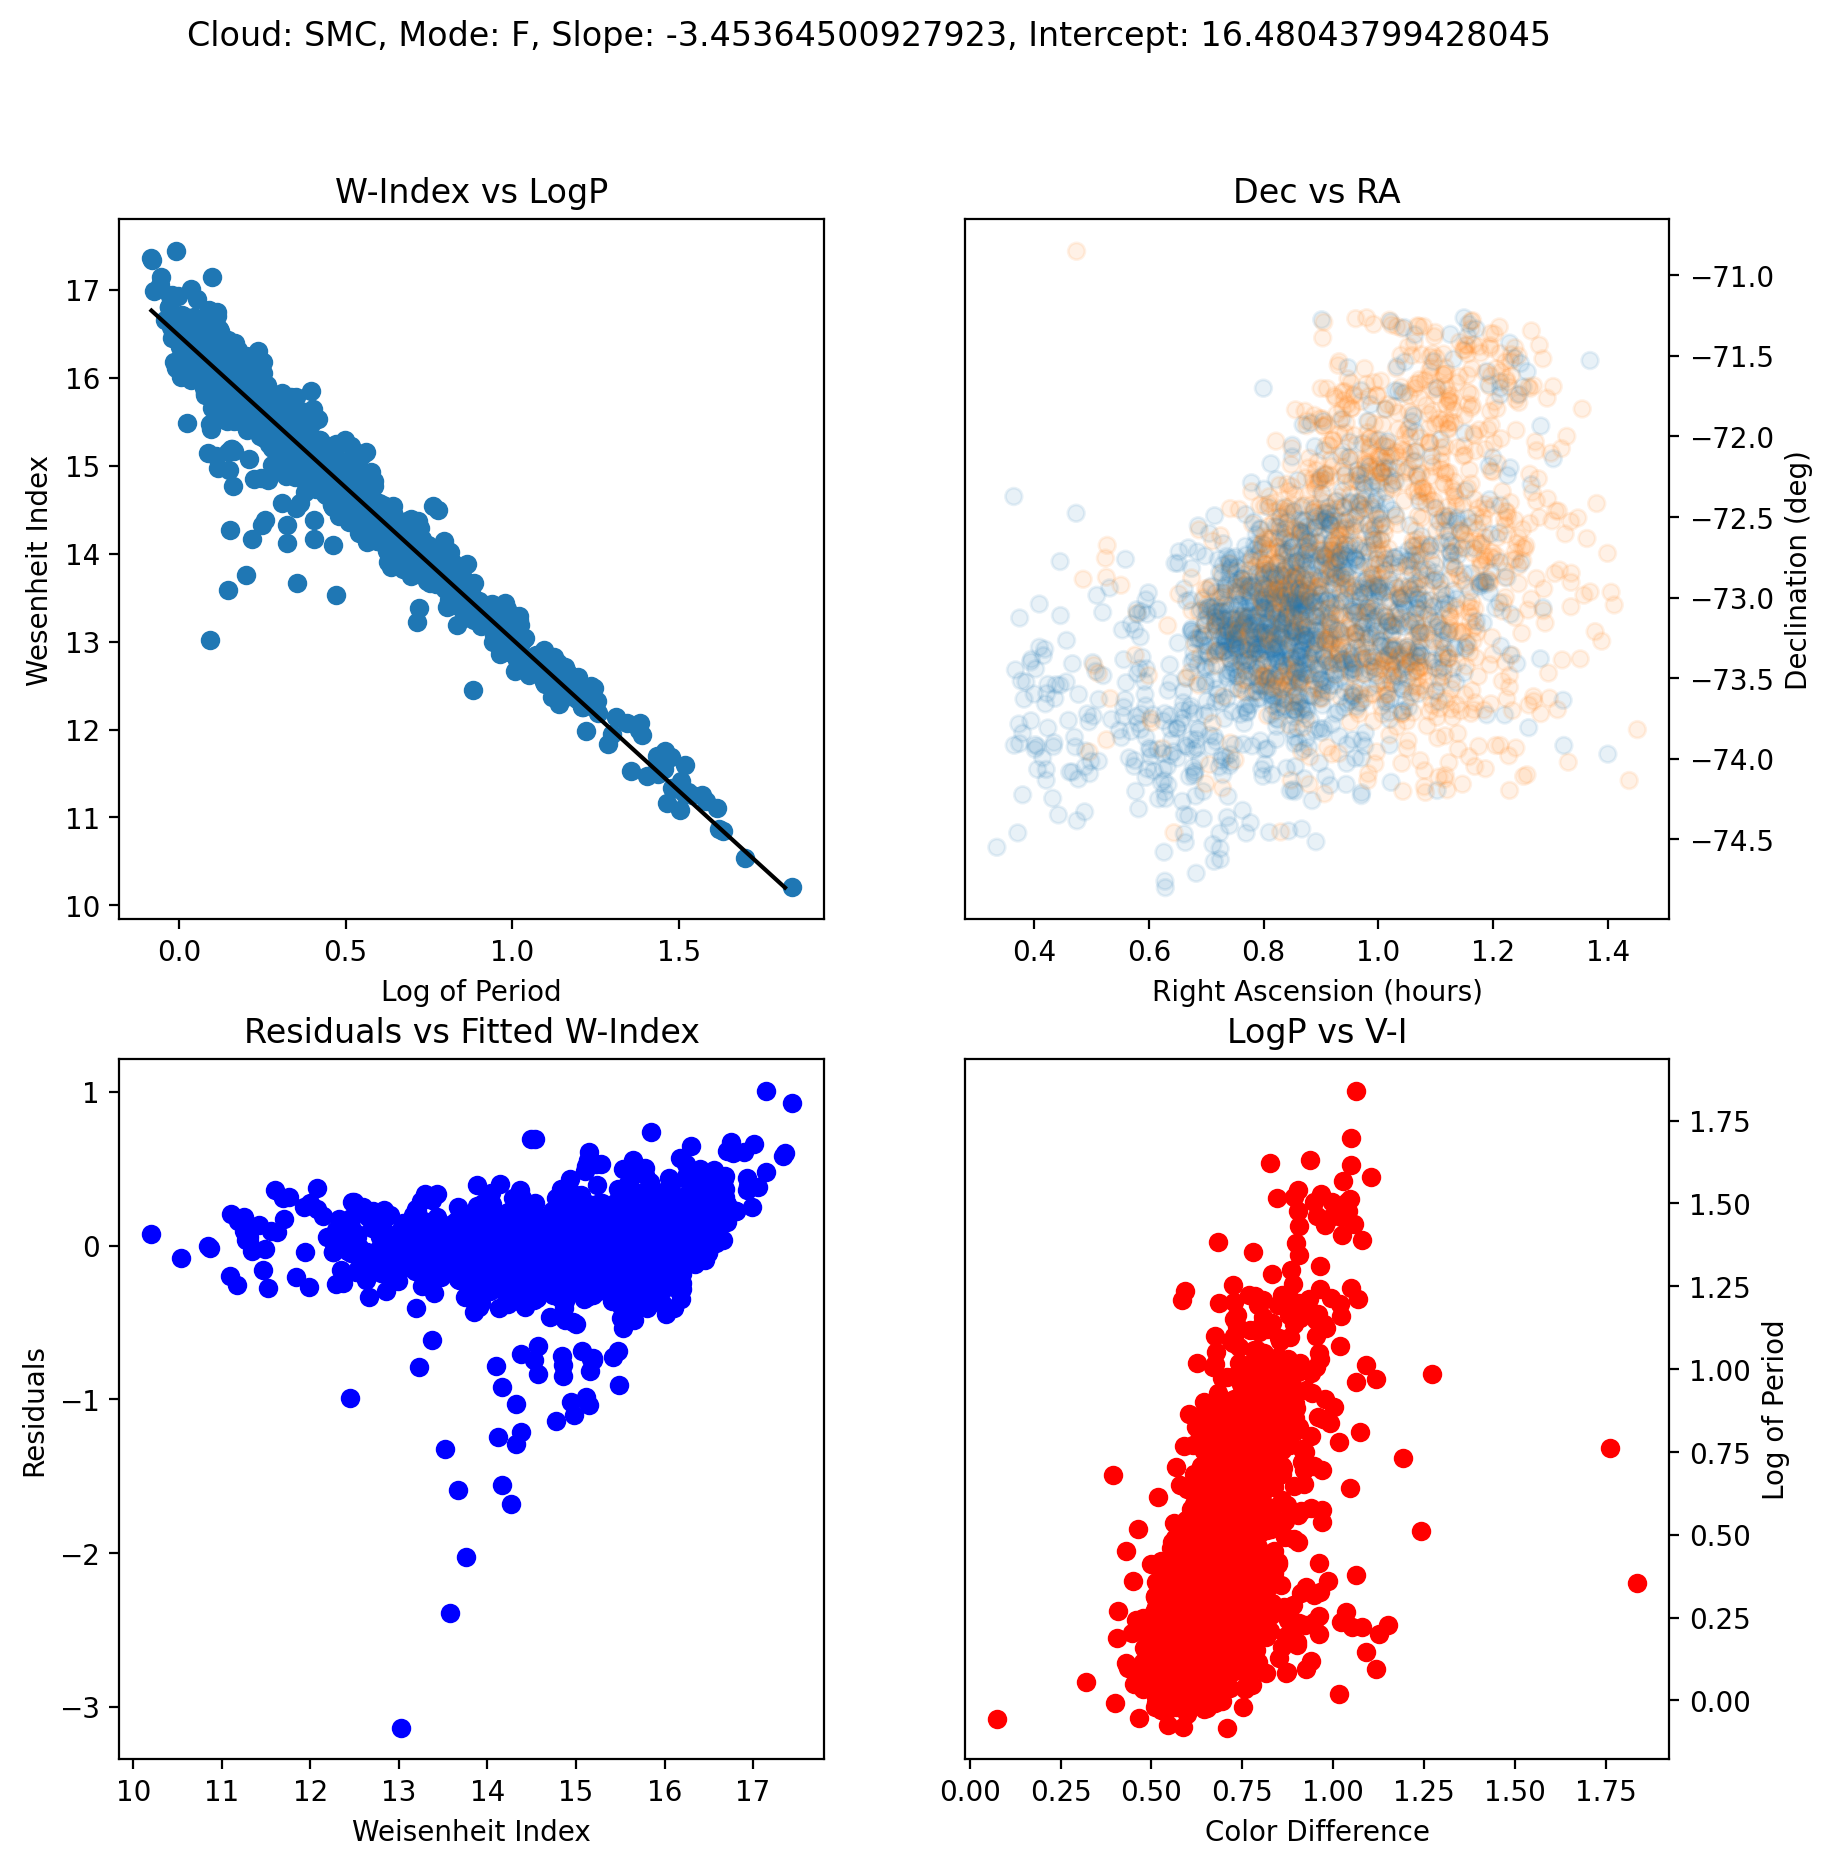

In [332]:
file = 'Cepheids.csv'


def main(data):
    tab = ascii.read(data, header_start=0, \
                   data_start=1, delimiter=',')
    #selecting mode and cloud from data
    mask1l = (tab['Mode'] == '1') & (tab['Cloud']=='LMC')
    mask1s = (tab['Mode'] == '1') & (tab['Cloud']=='SMC')
    maskFl = (tab['Mode'] == 'F') & (tab['Cloud']=='LMC')
    maskFs = (tab['Mode'] == 'F') & (tab['Cloud']=='SMC')
    masklist = [mask1l,mask1s,maskFl,maskFs]
    
    #applying selection masks and plotting for each of them
    for mask in masklist:
        data = tab[mask]
        x = data['logP1']
        y = data['W']
        #using my square loss function from Q1
        params = abfit(x,y, sig_y=1)
        plot_fit(data, params)

#This is a modified fitting function from my ASTR310 final.
def plot_fit(data,parameters):
    #define variables so that I didn't have to change my original code too much
    slope = parameters[1]
    intercept = parameters[0]
    cloud = data['Cloud'][0]
    mode = data['Mode'][0]
    
    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    #construct 'x' values to plug into y=mx+b
    logP = np.arange(data['logP1'].min(),data['logP1'].max(),0.1)
    #construct fitted W values from slope and intercept calculated earlier
    Wfit = slope*logP + intercept
    
    #scatter plot of W vs logP1
    ax1.scatter(data['logP1'],data['W'])
    ax1.plot(logP,Wfit,'k-')
    ax1.set_xlabel('Log of Period')
    ax1.set_ylabel('Wesenheit Index')
    ax1.set_title('W-Index vs LogP')
    
    #calculating the residuals
    residuals = data['W'] - slope*data['logP1']-intercept
    #assign a color to each residual point based on sign of residual
    resid_sign = ['C0' if resid>0 else 'C1' for resid in residuals]
    
    #scatter plot of RA vs Dec with colors assigned by resid_sign
    ax2.scatter(data['RA0'],data['Decl0'],marker = 'o',alpha = 0.1, color = resid_sign)
    ax2.set_xlabel('Right Ascension (hours)')
    ax2.set_ylabel('Declination (deg)')
    ax2.set_title('Dec vs RA')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    
    #title each plotted data set with its respective parameters
    fig.suptitle('Cloud: {}, Mode: {}, Slope: {}, Intercept: {}'.format(cloud,mode,slope,intercept))
    
    #scatter plot of rediduals vs W
    #from this plot, it appears as though a majority of the residuals are centered around 0, however they 
    # appear to have some skewness to them and therefore are not entirely gaussian
    ax3.scatter(data['W'],residuals, color='b')
    ax3.set_ylabel('Residuals')
    ax3.set_xlabel('Weisenheit Index')
    ax3.set_title('Residuals vs Fitted W-Index')
    
    #plot of logP1 vs V-I
    ax4.scatter(data['VI'], data['logP1'],color='r')
    ax4.set_xlabel('Color Difference')
    ax4.set_ylabel('Log of Period')
    ax4.set_title('LogP vs V-I')
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.tick_right()
    fig.savefig('{}_{}.png'.format(cloud,mode))
    plt.show(fig)
    return 'Plotted!'

main(file)